In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [64]:
df = pd.read_csv('/kaggle/input/spam-email-classification/email.csv')
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


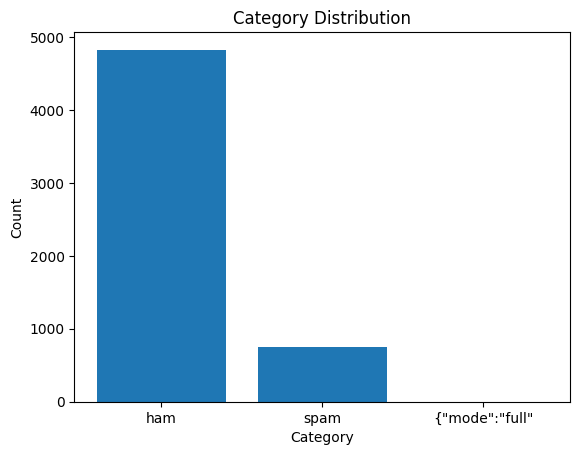

In [65]:

label_counts = df['Category'].value_counts()
plt.figure()
plt.bar(label_counts.index, label_counts.values) #label_counts.values → gives the counts ([4825, 747])
plt.title('Category Distribution')          #label_counts.index → gives the labels (["ham", "spam"])
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


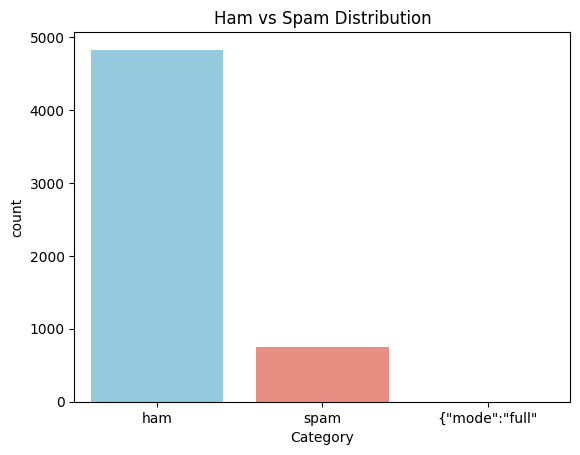

In [66]:
import seaborn as sns

sns.countplot(x='Category', data=df, palette=['skyblue','salmon'])
plt.title("Ham vs Spam Distribution")
plt.show()


In [67]:

def basic_clean(s):
    s = re.sub(r"http\\S+", " URL ", s)               # URLs
    s = re.sub(r"\\S+@\\S+", " EMAIL ", s)            # emails
    s = re.sub(r"\\d+", " NUM ", s)                   # numbers
    s = re.sub(r"[^a-zA-Z\\s]", " ", s)               # punctuation -> space
    s = re.sub(r"\\s+", " ", s).strip()
    return s.lower()

df['Message'] = df['Message'].fillna("").map(basic_clean)
df.Message.head(3)

0    go until jurong point  crazy   available only ...
1                           ok lar    joking wif u oni
2    free entry in   a wkly comp to win fa cup fina...
Name: Message, dtype: object

In [68]:
df['Category'] = df['Category'].map({'ham':0, 'spam':1})
df.head(3)

,Category,Message
0,0.0,go until jurong point crazy available only ...
1,0.0,ok lar joking wif u oni
2,1.0,free entry in a wkly comp to win fa cup fina...


In [69]:
print(df.isnull().sum())
df = df.dropna()
print(df.isnull().sum())

Category    1
Message     0
dtype: int64
Category    0
Message     0
dtype: int64


In [70]:
df.Category= df.Category.astype(int)
X = df.Message
y = df.Category
print(X[:3])
print(y[:3])

0    go until jurong point  crazy   available only ...
1                           ok lar    joking wif u oni
2    free entry in   a wkly comp to win fa cup fina...
Name: Message, dtype: object
0    0
1    0
2    1
Name: Category, dtype: int64


In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 32, stratify=y)

Text Vectorization (TF-IDF)
stop_words='english': removes common words (the, is, at) since they don’t help classification.

max_features=5000: only keep the top 5000 most important words to reduce dataset size & speed up training.

fit_transform(X_train): learn vocabulary from training emails & convert to TF-IDF matrix.

transform(X_test): use the same vocabulary to convert test emails.

In [72]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Models
Model 1: Naive Bayes
Model 2: Logistic Regression

In [73]:
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

MultinomialNB()

In [74]:
lr_model = LogisticRegression(max_iter=1000, class_weight='balanced', solver='liblinear')
lr_model.fit(X_train_vec, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, solver='liblinear')


🔹 Naive Bayes Results 🔹
Accuracy: 0.9775784753363229
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.83      0.91       149

    accuracy                           0.98      1115
   macro avg       0.99      0.92      0.95      1115
weighted avg       0.98      0.98      0.98      1115



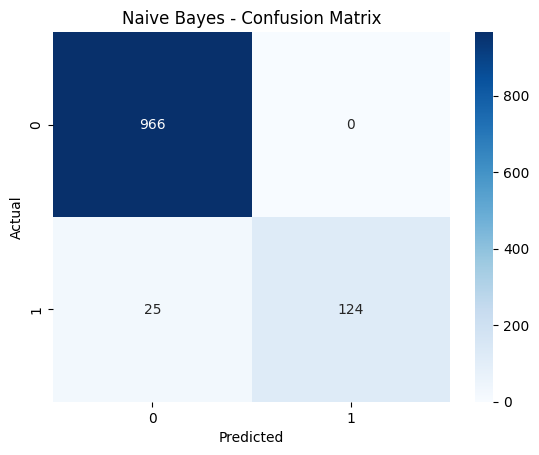


🔹 Logistic Regression Results 🔹
Accuracy: 0.9802690582959641
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       966
           1       0.93      0.93      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



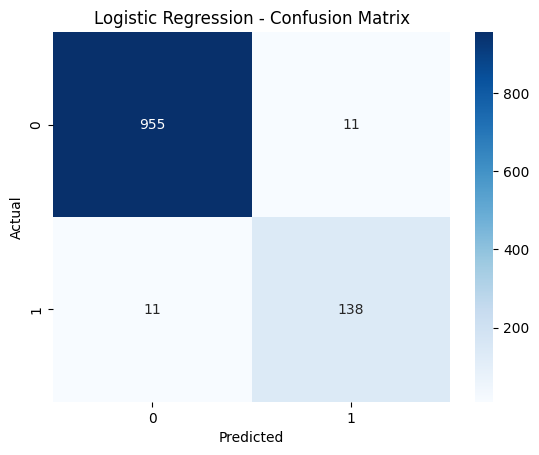

In [75]:
models = {'Naive Bayes': nb_model, 'Logistic Regression': lr_model}

for name, model in models.items():
    y_pred = model.predict(X_test_vec)
    print(f"\n🔹 {name} Results 🔹")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [76]:
test_emails = [
    "Congratulations! You've won a $1000 Walmart gift card. Click here to claim now!",
    "Hi John, can we meet tomorrow for the project discussion?"
]

test_vec = vectorizer.transform(test_emails)

print("\n🔎 Custom Predictions:")
for email, pred in zip(test_emails, nb_model.predict(test_vec)):
    print(f"Email: {email}\nPrediction: {'Spam' if pred==1 else 'Ham'}\n")


🔎 Custom Predictions:
Email: Congratulations! You've won a $1000 Walmart gift card. Click here to claim now!
Prediction: Spam

Email: Hi John, can we meet tomorrow for the project discussion?
Prediction: Ham

